In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

%reload_ext autoreload
%autoreload 2 

### Loading datasets

In [2]:
DATASET_NEMA_H0 = '../datasets/dataset_NEMA_NEMA_H0.csv'
DATASET_NEMA_H3 = '../datasets/dataset_NEMA_NEMA_H3.csv'
DATASET_NEMA_H15 = '../datasets/dataset_NEMA_NEMA_H15.csv'

In [11]:
from src.model.rc_dataset import ExperimentDataset


dataset_nema_h0 = ExperimentDataset(csv_path=DATASET_NEMA_H0)
dataset_nema_h3 = ExperimentDataset(csv_path=DATASET_NEMA_H3)
dataset_nema_h15 = ExperimentDataset(csv_path=DATASET_NEMA_H15)

datasets = [dataset_nema_h0, dataset_nema_h3, dataset_nema_h15]

### Target generator

In [44]:
from typing import List
from model_config import max_time_step


class TargetGenerator:
  """Transforms a dataset or list of datasets into a single target."""

  def __init__(self, *, target: str):
    self.target = target

  def transform(self, datasets: List[ExperimentDataset], *, warmup_days: int) -> np.ndarray:
    y = np.empty((1, 0))

    for dataset in datasets:
      assert self.target in dataset.get_targets(), f"{self.target} not available in dataset."
      run_id = dataset.get_run_ids()[0]
      y_dataset = dataset.get_target(self.target, run_id).to_numpy()
      y_dataset = y_dataset[:max_time_step[run_id]]
      y_dataset = y_dataset[24 * warmup_days:]
      y_dataset = y_dataset.reshape((1, -1))
      y = np.concatenate((y, y_dataset), axis=1)

    return y

In [45]:
from model_config import targets

target_generator = TargetGenerator(target=targets[0])
y_raw = target_generator.transform(datasets, warmup_days=4)

print(f'y_raw shape: {y_raw.shape}')

y_raw shape: (1, 2136)


### Reservoir generators

In [46]:
from abc import ABC, abstractmethod

class ReservoirGenerator(ABC):

  @abstractmethod
  def transform(self, datasets: List[ExperimentDataset], *, warmup_days: int) -> np.ndarray:
    pass

#### Homogeneous reservoirs

In [73]:
class HomogeneousReservoirGenerator(ReservoirGenerator):

  def __init__(self, *, state_var: str):
    self.state_var = state_var

  def transform(self, datasets: List[ExperimentDataset], *, warmup_days: int) -> np.ndarray:
    X = None

    for dataset in datasets:
      assert (self.state_var in dataset.get_state_variables()), f"{self.state_var} not available in dataset."
      run_id = dataset.get_run_ids()[0]
      X_dataset = dataset.get_state(self.state_var, run_id)
      X_dataset = X_dataset[:max_time_step[run_id]]
      X_dataset = X_dataset[24 * warmup_days:]

      # Filter out NaN and zero series
      X_NaN = np.isnan(X_dataset)
      NaN_idx = np.any(X_NaN, axis=0)
      X_null = np.isclose(X_dataset, 0)
      null_idx = np.all(X_null, axis=0)
      X_dataset = X_dataset[:, ~NaN_idx & ~null_idx]

      X_dataset = X_dataset.reshape(1, *X_dataset.shape)

      if X is None:
        X = X_dataset
      else:
        X = np.concatenate((X, X_dataset), axis=1)

    return X

In [74]:
from model_config import state_variables

reservoir_generator = HomogeneousReservoirGenerator(state_var=state_variables[2])
X_raw = reservoir_generator.transform(datasets, warmup_days=4)

print(f'X_raw shape: {X_raw.shape}')

X_raw shape: (1, 2136, 10)


#### Heterogeneous reservoirs

In [85]:
class HeterogeneousReservoirGenerator(ReservoirGenerator):

  def __init__(self, *, state_vars: List[str]):
    self.state_vars = state_vars

  def transform(self, datasets: List[ExperimentDataset], *, warmup_days: int) -> np.ndarray:
    X = None
    for state_var in self.state_vars:
      reservoir_generator = HomogeneousReservoirGenerator(state_var=state_var)
      X_raw_var = reservoir_generator.transform(datasets, warmup_days=warmup_days)
      if X is None:
        X = X_raw_var
      else:
        X = np.concatenate((X, X_raw_var), axis=2)
    return X

In [86]:
reservoir_generator = HeterogeneousReservoirGenerator(state_vars=state_variables)
X_raw = reservoir_generator.transform(datasets, warmup_days=4)

print(f'X_raw shape: {X_raw.shape}')

X_raw shape: (1, 2136, 122)


#### Environment baseline reservoirs

In [88]:
class TargetReservoirGenerator(ReservoirGenerator):

  def __init__(self, *, targets: List[str]):
    self.targets = targets

  def transform(self, datasets: List[ExperimentDataset], *, warmup_days: int) -> np.ndarray:
    X = None
    for target in self.targets:
      target_generator = TargetGenerator(target=target)
      X_raw_target = target_generator.transform(datasets, warmup_days=warmup_days)
      X_raw_target = X_raw_target.reshape((*X_raw_target.shape, 1))
      if X is None:
        X = X_raw_target
      else:
        X = np.concatenate((X, X_raw_target), axis=2)
    return X

In [106]:
from model_config import input_targets

reservoir_generator = TargetReservoirGenerator(targets=input_targets)
X_raw = reservoir_generator.transform(datasets, warmup_days=4)

print(f'X_raw shape: {X_raw.shape}')

X_raw shape: (1, 2136, 3)


### Group generator

In [125]:
class GroupGenerator:

  def __init__(self, *, day_length: int):
    self.day_length = day_length

  def transform(self, datasets: List[ExperimentDataset], *, warmup_days: int) -> np.ndarray:
    groups = np.empty((1, 0))
    for dataset in datasets:
      groups_dataset = self._dataset_group_by_day(dataset, warmup_days)
      groups = np.concatenate((groups, groups_dataset), axis=1)
    return groups

  def _dataset_group_by_day(self, dataset: ExperimentDataset, warmup_days: int):
    run_id = dataset.get_run_ids()[0]
    n_steps = max_time_step[run_id] - self.day_length * warmup_days
    assert n_steps % self.day_length == 0, "Datasets must have a multiple of day length time samples."
    n_groups = n_steps // self.day_length
    groups = np.arange(n_groups).repeat(self.day_length)
    groups = groups.reshape((1, -1))
    return groups
   

In [145]:
group_generator = GroupGenerator(day_length=24)

groups_raw = group_generator.transform(datasets, warmup_days=4)

print(f'Groups_raw shape: {groups_raw.shape}')
print(f'Unique groups: {len(np.unique(groups_raw))}')
print(groups_raw[0, 0:7*24:24])

Groups_raw shape: (1, 2136)
Unique groups: 33
[0. 1. 2. 3. 4. 5. 6.]


### Target transformers

In [146]:
class TargetTransformer(ABC):

  @abstractmethod
  def transform(self, y_raw: np.ndarray) -> np.ndarray:
    pass

#### Direct target (no transform)

In [147]:
class DirectTarget(TargetTransformer):

  def transform(self, y_raw: np.ndarray) -> np.ndarray:
    return y_raw

In [148]:
target_tf = DirectTarget()
y_tf = target_tf.transform(y_raw)

print(y_tf.shape)

(1, 2136)


### Reservoir transformers

In [149]:
class ReservoirTransformer(ABC):

  @abstractmethod
  def transform(self, X_raw: np.ndarray) -> np.ndarray:
    pass

#### Direct reservoir (no transform)

In [150]:
class DirectReservoir(ReservoirTransformer):

  def transform(self, X_raw: np.ndarray) -> np.ndarray:
    return X_raw

In [151]:
reservoir_tf = DirectReservoir()
X_tf = reservoir_tf.transform(X_raw)

print(X_tf.shape)

(1, 2136, 3)


### Flatten data

In [157]:
from typing import Tuple

def flatten(X_tf, y_tf, groups) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  assert X_tf.shape[:2] == y_tf.shape == groups.shape
  _, n_samples, n_features = X_tf.shape
  X = X_tf.reshape((-1, n_features))
  y = y_tf.reshape((n_samples))
  groups = groups.reshape((n_samples))
  return X, y, groups

In [176]:
X, y, groups = flatten(X_tf, y_tf, groups_raw)

print(X.shape)
print(y.shape)
print(groups.shape)

(2136, 3)
(2136,)
(2136,)


### Data preprocessors

In [162]:

class Preprocessor(ABC):

  @abstractmethod
  def transform(self, X, y, groups) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    return X, y, groups

#### Daylight masking

In [180]:
from src.learning.preprocessing import generate_mask

class DaylightMask(Preprocessor):

  def __init__(self, *, day_length: int, start: int, end: int):
    self.daylight_mask = generate_mask(start, end, length=day_length)

  def transform(self, X, y, groups) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    assert len(X) == len(y) == len(groups)
    n_days = X.shape[0] // len(self.daylight_mask)
    time_mask = np.tile(self.daylight_mask, n_days)
    X = X[time_mask]
    y = y[time_mask]
    groups = groups[time_mask]
    return X, y, groups

In [181]:
day_mask_tf = DaylightMask(day_length=24, start=5, end=21)
X_day, y_day, groups_day = day_mask_tf.transform(X, y, groups)

print(X_day.shape, y_day.shape, groups_day.shape)

(1424, 3) (1424,) (1424,)


#### Rescaling

In [164]:
class StandardScaler(Preprocessor):

  def transform(self, X, y, groups) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    X = (X - X.mean()) / X.std()
    y = (y - y.mean()) / y.std()
    return X, y, groups

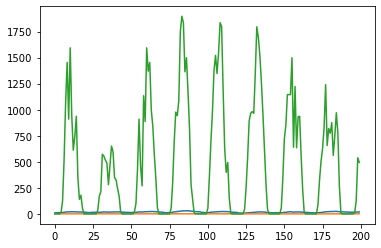

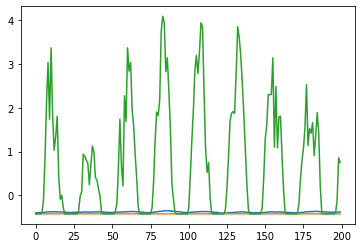

In [185]:
plt.plot(X[:200])
plt.show()

scaler_tf = StandardScaler()
X_scaled, _, _ = scaler_tf.transform(X, y, groups)

plt.plot(X_scaled[:200])
plt.show()